
# SMU Course Bidding Data Preprocessing

This notebook performs the following steps:
1. **Data Cleaning** - Handle redundant columns and remove unwanted data.
2. **Feature Engineering** - Create derived features.
3. **Exploratory Data Analysis (EDA)** - Analyze key features and correlations.
4. **Further Data Cleaning** - Removing high multicollinear variables.
5. **Save Processed Data** - Save the data into a csv that is useable for other ML models

---
### Requirements
- Python 3.x
- TensorFlow, Pandas, NumPy, Matplotlib, Seaborn, Sklearn

---


In [30]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [31]:
# Set up folder path containing all Excel files
data_folder = 'overallBossResults'
data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.xls')]

# Load and combine data
dataframes = [pd.read_excel(file) for file in data_files]
data = pd.concat(dataframes, ignore_index=True)

# Basic data checks
print(f"Loaded {len(data_files)} files.")
print("Initial Data Shape:", data.shape)
print(data.head())

Loaded 12 files.
Initial Data Shape: (121221, 16)
             Term                   Session     Bidding Window Course Code  \
0  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT001   
1  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT009   
2  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
3  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
4  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   

                                         Description Section  Vacancy  \
0  Accounting Study Mission (Asian Studies)(Bangkok)      G1       45   
1  Overseas Project Experience (Accounting in Asi...      G1       25   
2                               Financial Accounting      G1       42   
3                               Financial Accounting     G10       45   
4                               Financial Accounting     G11       45   

   Opening Vacancy  Before Process Vacancy


## 1. Data Cleaning

Steps:
1. Remove rows where 'Min Bid' is 0.
2. Drop redundant columns:
    - `Session`
    - `D.I.C.E`
    - `School/Department`
    - `Opening Vacancy`
3. Handle missing values (if any).
    

In [32]:
# Data Cleaning
# 1. Remove rows where 'Min Bid' == 0
data = data[data['Min Bid'] != 0]

# 2. Drop redundant columns
columns_to_drop = ['Session', 'D.I.C.E', 'School/Department', 'Opening Vacancy']
data = data.drop(columns=columns_to_drop, errors='ignore')

# 3. Handle missing values
data['Instructor'] = data['Instructor'].fillna("Not Assigned Yet")

## 2. Feature Engineering

Steps:
1. Create `AY` and `Term` columns from `Term` column.
2. Transform `Bidding Window` into `Round` and `Window`.
3. Split `Course Code` into `SubjectArea` and `CatalogueNo`.
4. Perform embeddings for text and categorical columns:
    - `Description`, `SubjectArea`, `Section`, `Instructor`
5. Create derived columns:
    - `BidderCount`: `Before Process Vacancy` - `After Process Vacancy`
    - `CurrEnrolledCount`: `Enrolled Students` - `BidderCount`
    

In [33]:
# Feature Engineering
# Extract AY and Term
data['AY'] = data['Term'].str[:4]
data['Term'] = data['Term'].str.split('Term ', expand=True)[1].str.strip()

# Extract Round and Window from 'Bidding Window'
data['Round'] = data['Bidding Window'].str.extract(r'Round (\d[A-B]?)')
data['Window'] = data['Bidding Window'].str.extract(r'Window (\d)')

# Extract SubjectArea and CatalogueNo from 'Course Code'
data['SubjectArea'] = data['Course Code'].str.extract(r'([A-Za-z-]+)')
data['CatalogueNo'] = data['Course Code'].str.extract(r'(\d+)$')

# Create BidderCount and CurrEnrolledCount
data['BidderCount'] = data['Before Process Vacancy'] - data['After Process Vacancy']
data['CurrEnrolledCount'] = data['Enrolled Students'] - data['BidderCount']

# Drop columns used for derived features
data = data.drop(columns=['Bidding Window', 'Course Code', 'Before Process Vacancy', 
                          'After Process Vacancy', 'Enrolled Students'], errors='ignore')

# After extracting AY and Window from strings, convert them to numeric
data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
data['Window'] = pd.to_numeric(data['Window'], errors='coerce')

# Round 2A has no window, thus has to be assigned -1
data['Window'] = data['Window'].fillna(-1).astype(int)

# Manual mapping for Term
# Term dropdown: 1, 2, 3A, 3B
term_map = {
    '1': 1,
    '2': 2,
    '3A': 3,
    '3B': 4
}

data['Term'] = data['Term'].map(term_map)

# Manual mapping for Round
# Round dropdown: 1, 1A, 1B, 1C, 2, 2A
round_map = {
    '1': 1,
    '1A': 2,
    '1B': 3,
    '1C': 4,
    '2': 5,
    '2A': 6
}

data['Round'] = data['Round'].map(round_map)

print("Data after Cleaning and Feature Engineering:")
print(data.head())
print(data.info())

Data after Cleaning and Feature Engineering:
    Term                       Description Section  Vacancy  Median Bid  \
45     2  Financial Reporting and Analysis      G3       42       25.00   
64     2                         Valuation      G1       42       10.09   
65     2                         Valuation      G2       42       10.03   
73     2    Auditing for the Public Sector      G1       42       25.00   
96     2          Public Relations Writing      G1       45       10.00   

    Min Bid            Instructor    AY  Round  Window SubjectArea  \
45    25.00          GOH BENG WEE  2021    6.0       3        ACCT   
64    10.09        CHENG NAM SANG  2021    6.0       3        ACCT   
65    10.00        CHENG NAM SANG  2021    6.0       3        ACCT   
73    25.00          LIM SOO PING  2021    6.0       3        ACCT   
96    10.00   YASMIN HANNAH RAMLE  2021    6.0       3        COMM   

   CatalogueNo  BidderCount  CurrEnrolledCount  
45         224            1       


## 3. Exploratory Data Analysis (EDA)

### Steps:
1. Explore statistics and distributions of all variables.
2. Perform corrleation heatmap on numerical variables. Perform feature selection afterwards to remove high multicollinear variables.


### Descriptive statistics

In [34]:
# 1. Print descriptive statistics for all columns
print("=== Descriptive Statistics (All Columns) ===")
display(data.describe(include='all'))

=== Descriptive Statistics (All Columns) ===


,Term,Description,Section,Vacancy,Median Bid,Min Bid,Instructor,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount,CurrEnrolledCount
count,36718.000000,36718,36718,36718.000000,36718.000000,36718.000000,36718,36718.000000,31601.000000,36718.000000,36718,36718,36718.000000,36718.000000
unique,NaN,668,45,NaN,NaN,NaN,931,NaN,NaN,NaN,55,373,NaN,NaN
top,NaN,Management Communication,G1,NaN,NaN,NaN,Not Assigned Yet,NaN,NaN,NaN,COR,101,NaN,NaN
freq,NaN,1394,14491,NaN,NaN,NaN,516,NaN,NaN,NaN,5469,2785,NaN,NaN
mean,1.550874,NaN,NaN,43.654611,29.110291,24.532293,NaN,2022.612642,2.657542,1.152650,NaN,NaN,6.335884,26.779018
std,0.504372,NaN,NaN,40.209872,20.306400,19.353522,NaN,1.011167,1.596197,1.043037,NaN,NaN,9.589741,15.328644
min,1.000000,NaN,NaN,1.000000,10.000000,10.000000,NaN,2021.000000,1.000000,-1.000000,NaN,NaN,-2.000000,-2.000000
25%,1.000000,NaN,NaN,45.000000,15.350000,10.502500,NaN,2022.000000,1.000000,1.000000,NaN,NaN,1.000000,16.000000
50%,2.000000,NaN,NaN,45.000000,24.820000,18.460000,NaN,2023.000000,2.000000,1.000000,NaN,NaN,2.000000,32.000000
75%,2.000000,NaN,NaN,45.000000,36.000000,30.890000,NaN,2023.000000,3.000000,2.000000,NaN,NaN,6.000000,40.000000


### Outlier fixing

1. There are three rows affected with vacancy of 4445. Replace with 45.

In [35]:
# Replace all rows where Vacancy is 4445 with 45
data.loc[data['Vacancy'] == 4445, 'Vacancy'] = 45

### Correlation heatmap

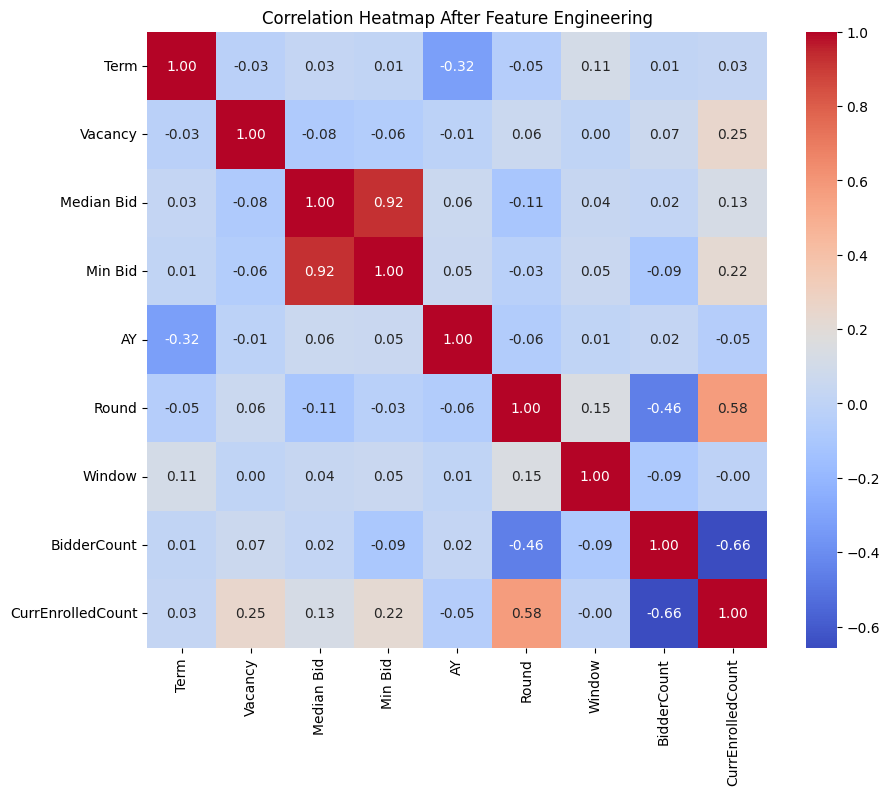

In [36]:
# Check distributions and correlations post feature engineering
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap After Feature Engineering")
plt.show()

### Insights from Correlation Heatmap Analysis

1. MinBid and MedianBid – (0.93)
    - **Reason**: MinBid is around MedianBid when bidder count is low (1-3 people).
    - **Action**: Remove MedianBid since it’s redundant in this case.

2. BidderCount and CurrEnrolledCount (-0.67)
    - **Reason**: CurrEnrolledCount uses BidderCount as part of the formula:
        - Formula: ‘Enrolled Student’ – ‘BidderCount’.
    - **Action**: Might have to delete CurrEnrolledCount to maintain independence (avoid multicollinearity) between variables.

3. Round and CurrEnrolledCount (0.53)
    - **Reason**: CurrEnrolledCount will be higher as rounds progress, as most classes get full.
    - **Action**: CurrEnrolledCount will need to be removed as per point 2.

4. Round and BidderCount (-0.41)
    - **Reason**: As there are more rounds, there will be fewer bidders. Most students secure their spots early to prevent inflation from supply squeeze.
    - **Action**: No removal; this is a natural relationship.

5. MinBid vs CurrEnrolledCount (0.22)
    - **Reason**: If there is less CurrEnrolledCount, MinBid will be lower due to higher supply.
    - **Action**: CurrEnrolledCount will need to be removed as per point 2.

6. Round and Window (0.14)
    - **Reason**: Can't think of a good reason.
    - **Action**: No removal; this is a natural relationship.

### Interesting thing about insights vs personal intuition
1. Initially expected BidderCount to be highly negatively correlated with MinBid since having lesser people bid means lesser minimum bid prices. Data shows that this is not true.

## 4. Further data cleaning

### Steps:
1. Remove redundant variable - Median Bid
2. Remove derived variable - CurrEnrolledCount

In [37]:
additional_columns_to_drop = ['Median Bid', 'CurrEnrolledCount']
data = data.drop(columns=additional_columns_to_drop)


## 5. Save data into CSV
    

In [38]:
# Save the transformed data to a CSV file
output_path = 'transformed_data.csv'
data.to_csv(output_path, index=False)
print(f"Data successfully saved to {output_path}")

Data successfully saved to transformed_data.csv
